# Charger Reliability Problem

## Data 

In [362]:
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

## Stations Overview

In [363]:
df_stations = pd.read_csv("data/stations/stations_overview.csv")

In [364]:
df_stations.columns

Index(['Station Name', 'Org Name', 'MAC Address', 'System S/N', 'Address 1',
       'Address 2', 'Floor Label', 'City', 'State', 'Zip/Postal Code',
       'County', 'Country ', 'Activation Status', 'Network Status',
       'Station Status', 'Port 1 Status', 'Port 2 Status', 'No. of Ports',
       'Pricing Policy Name', 'Reservations', 'Station Message', 'Enabled',
       'Station Activation Type', 'Usable By',
       'Visibility (Access Policy Name)', 'Radio Group Name',
       'Customer Category', 'Customer Subcategory', 'Circuit Sharing',
       'Currency Name', 'Power Select / AC Breaker Rating',
       'Scheduled Charging Policy Name', 'Warranty', 'Station Activation Date',
       'Warranty Expiration Date', 'Warranty Service',
       'Device Access Restriction', 'Waitlist Policy Name', 'Asset Tag ID',
       'Meter ID', 'Service Delivery Point ID', 'Point of Service ID',
       'Account ID', 'Circuit ID', 'Panel ID', 'Customer Name', 'Customer ID',
       'Site Validation Status',

In [365]:
print('Number of stations:')
print(df_stations['Station Name'].nunique())
print('Cities:')
print(df_stations['City'].unique())
print('Number of Parking lots: ')
print(df_stations['Address 1'].nunique())
print('Counties:')
print(df_stations['County'].unique())
print('Network Status:')
print(df_stations['Network Status'].unique())
print('Station Status:')
print(df_stations['Station Status'].unique())
print('Number of ports:')
print(df_stations['No. of Ports'].value_counts())
print('Pricing Policy:')
print(df_stations['Pricing Policy Name'].value_counts())


Number of stations:
109
Cities:
['Stanford' 'Menlo Park' 'Palo Alto' 'Redwood City']
Number of Parking lots: 
20
Counties:
['Santa Clara County' nan 'San Mateo County']
Network Status:
['Unreachable' 'Reachable']
Station Status:
['Watch List' 'Available' 'Inuse' 'Needs Service']
Number of ports:
No. of Ports
2    96
1    13
Name: count, dtype: int64
Pricing Policy:
Pricing Policy Name
$1 per hr enforcement hours                           89
$2 per hr enforcement hours $1 per hr otherwise (e    19
Stanford University Mirrored                           1
Name: count, dtype: int64


In [366]:
print(df_stations['Customer Category'].value_counts())
print(df_stations['Customer Subcategory'].value_counts())
print(df_stations['Circuit Sharing'].value_counts())
print(df_stations['Power Select / AC Breaker Rating'].value_counts())

Customer Category
Education    96
Workplace    13
Name: count, dtype: int64
Customer Subcategory
University / College    96
General                 13
Name: count, dtype: int64
Circuit Sharing
Disabled    74
Enabled     35
Name: count, dtype: int64
Power Select / AC Breaker Rating
40A    89
30A     3
Name: count, dtype: int64


In [367]:
print(df_stations['Customer Name'].value_counts())
print(df_stations['Warranty'].value_counts())
print(df_stations['Site Validation Status'].value_counts())

Customer Name
Stanford Parking & Transportation Services                        6
ABM Electrical & Lighting Solutions, LLC (SoCal)                  4
The Board of Trustees of The Leland Stanford Junior University    4
Stanford University                                               3
Oak Park Unified School District                                  1
Name: count, dtype: int64
Warranty
ChargePoint Assure    76
Standard Warranty     33
Name: count, dtype: int64
Site Validation Status
Validated        91
Not Validated    18
Name: count, dtype: int64


In [368]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Station Name                      109 non-null    object 
 1   Org Name                          109 non-null    object 
 2   MAC Address                       109 non-null    object 
 3   System S/N                        109 non-null    int64  
 4   Address 1                         109 non-null    object 
 5   Address 2                         1 non-null      object 
 6   Floor Label                       26 non-null     object 
 7   City                              109 non-null    object 
 8   State                             109 non-null    object 
 9   Zip/Postal Code                   109 non-null    int64  
 10  County                            104 non-null    object 
 11  Country                           109 non-null    object 
 12  Activati

## Alarms

In [369]:
df_alarms = pd.read_csv('data/reports/alarms/alarms.csv')
df_alarms['Alarm Time'] = df_alarms['Alarm Time'].str.replace(' (PDT)', '')
df_alarms['Alarm Time'] = df_alarms['Alarm Time'].str.replace(' (PST)', '')
df_alarms['Alarm Time'] = pd.to_datetime(df_alarms['Alarm Time']).dt.tz_localize('America/Los_Angeles',ambiguous='NaT')

Period Horizon

In [370]:
print(df_alarms['Alarm Time'].min())
print(df_alarms['Alarm Time'].max())

2022-04-21 12:46:51-07:00
2023-09-26 14:47:28-07:00


In [371]:
df_alarms.columns

Index(['Display Name', 'MAC Address', 'Org Name', 'Alarm Severity',
       'Alarm Name', 'Alarm ID', 'FRU Name', 'Alarm Time', 'Model Number',
       'Port', 'Reason For Clearing', 'Component Serial Number'],
      dtype='object')

In [372]:
df_alarms['Model Number'].value_counts()

Model Number
CT4020-HD            87899
CT4020-HD-GW         65744
CT4010-HD-GW         18810
CT4010-HD             7466
CT4020-HD2-GW-LTE       81
Name: count, dtype: int64

* Model-Options. Software, Services, and Misc
* 4020 -> 2 ports
* 4010 -> 1 port
* HD ->
* HD2 ->
* GW -> Integral Gateway Modem (GW1 US / GW2 Canada)
* LTE -> 4G LTE (Wide area network)


CT4020-HD-GW -> https://www.capitalelectricsupply.com/product/detail/1670587/chargepoint-inc-ct4020-hd-gw-lte

Mapping IDs to Alarm types

In [373]:
def map_alarm_types_to_ids(df_alarms):    
    alarm_ids_dict = {}
    ids = list(df_alarms['Alarm ID'].unique())
    for id in ids:
        alarm_ids_dict[id] = list(df_alarms[df_alarms['Alarm ID']==id]['Alarm Name'].unique())
    return alarm_ids_dict


In [374]:
alarm_ids_dict = map_alarm_types_to_ids(df_alarms)
alarm_ids_dict

{nan: [],
 23.0: ['Tamper Detect'],
 18.0: ['Fault Cleared', 'Pilot Unreachable (18)'],
 27.0: ['Data Partition Full', 'Fault Cleared'],
 33.0: ['Hardware Fault Station Out Of Service'],
 29.0: ['Fault Cleared', 'Grace Sessions Exceeded'],
 4.0: ['Fault Cleared', 'GFCI Soft Trip'],
 24.0: ['RFID Update Failed'],
 8.0: ['Relay Stuck Close'],
 2.0: ['Pilot current level exceeded', 'Fault Cleared'],
 28.0: ['Fault Cleared', 'Hardware Fault'],
 25.0: ['Earth Fault Station In Service', 'Fault Cleared'],
 5.0: ['Fault Cleared', 'GFCI Hard Trip'],
 30.0: ['Earth Fault Station Out Of Service'],
 17.0: ['Fault Cleared', 'Ventilation Fault']}

### Alarms - Chargers

In [375]:
print(df_alarms['Display Name'].value_counts())

Display Name
STANFORD / STATION 1 TMU    21829
SRWC / RWC L5 3             11338
SRWC / RWC L5 5              6851
SRWC / RWC L5 1              6737
SRWC / RWC L5 2              6707
                            ...  
STANFORD / STATION 1           59
STANFORD / STATION 3           54
STANFORD / STATION 2           50
STANFORD / STATION 4           49
STANFORD / STATION 10          46
Name: count, Length: 110, dtype: int64


<Axes: >

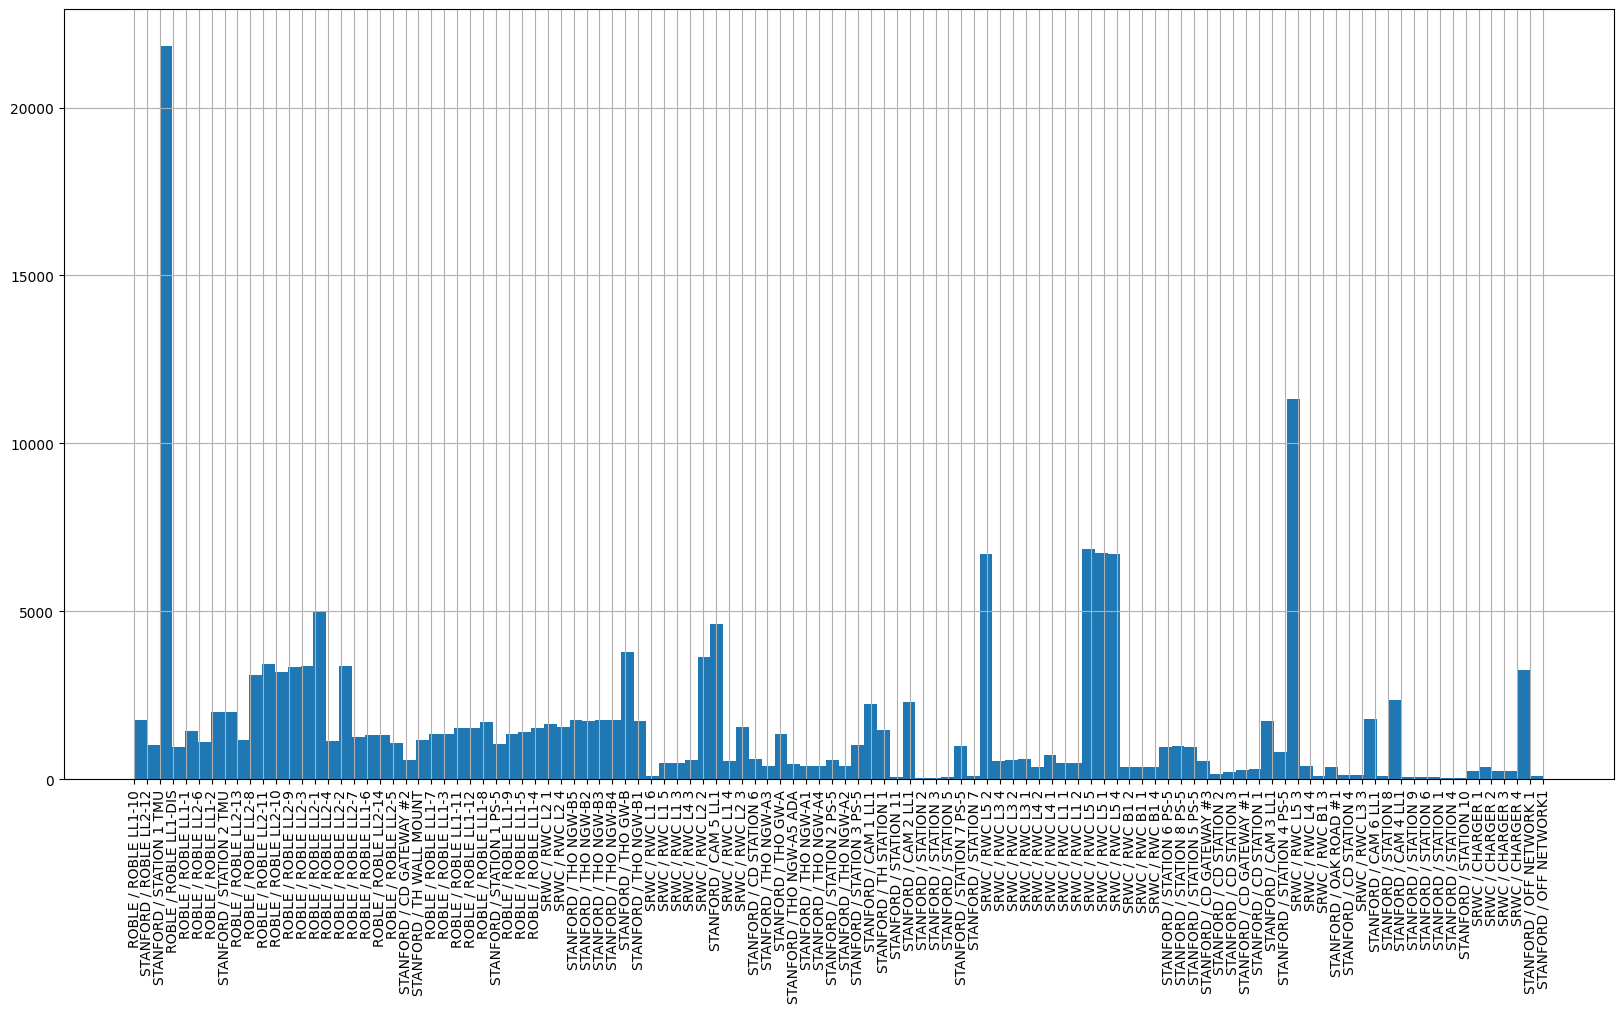

In [376]:
plt.figure(figsize=(20,10)) 
df_alarms['Display Name'].hist(xrot=90,bins=df_alarms['Display Name'].nunique())

<Axes: >

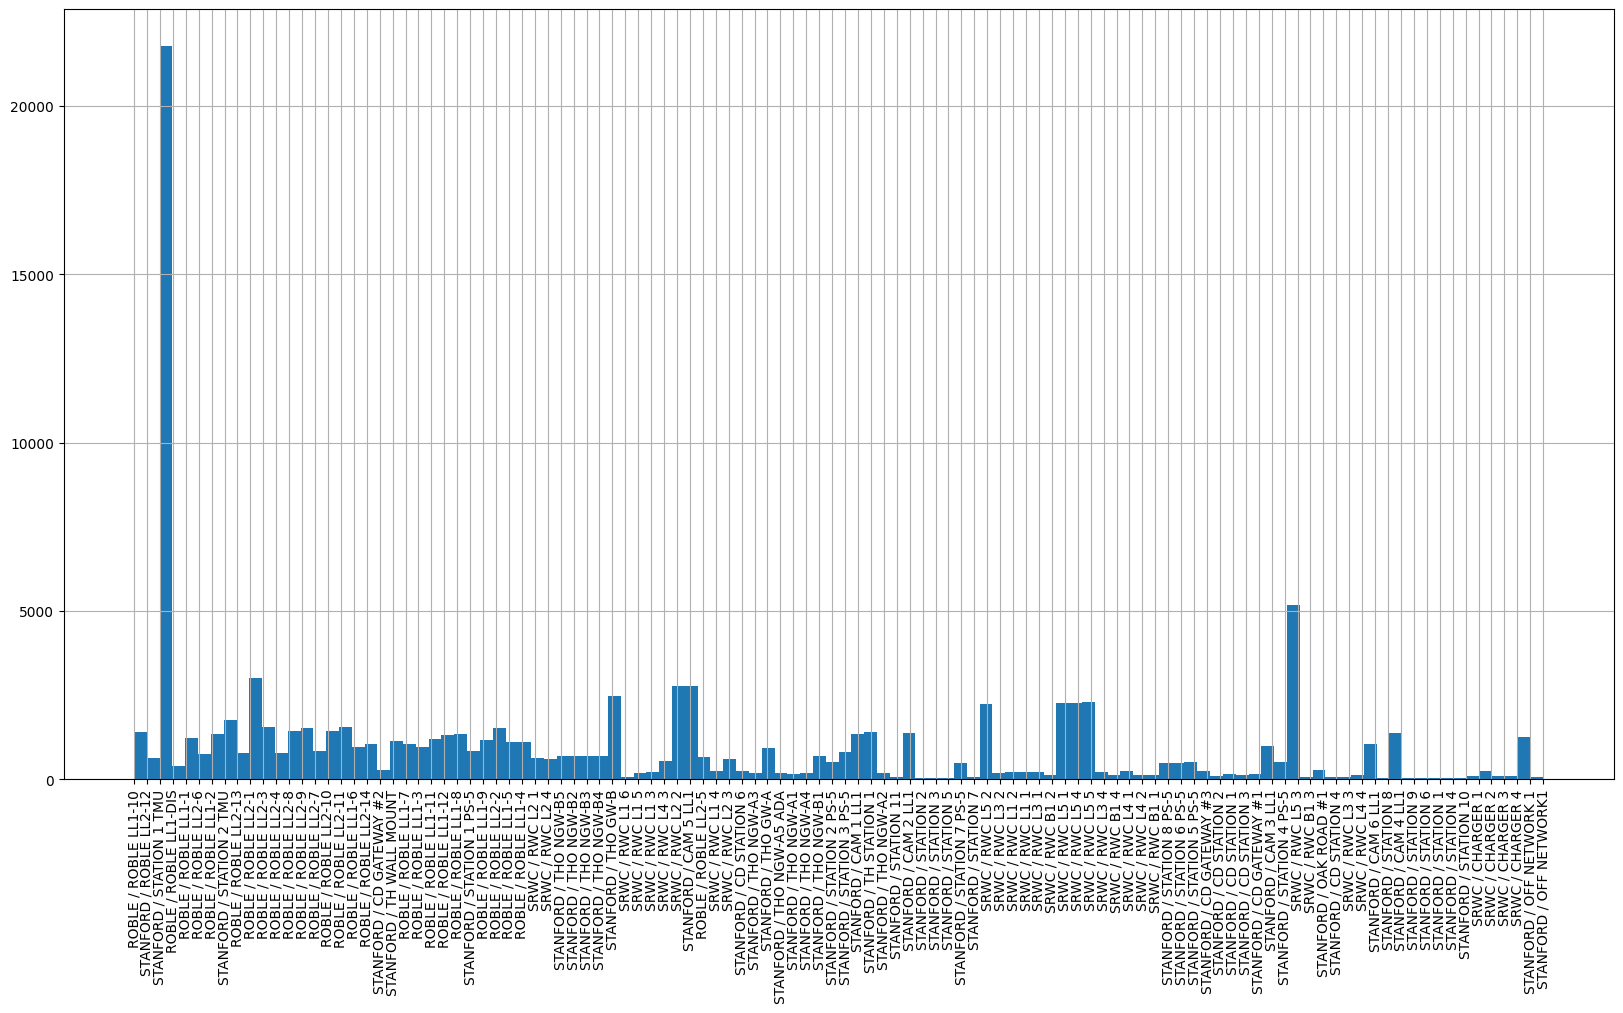

In [377]:
plt.figure(figsize=(20,10)) 
df_alarms['Display Name'][df_alarms['Alarm Name']!='Reachable'].hist(xrot=90,bins=df_alarms['Display Name'].nunique())

In [378]:
print(df_alarms['Display Name'].value_counts())

Display Name
STANFORD / STATION 1 TMU    21829
SRWC / RWC L5 3             11338
SRWC / RWC L5 5              6851
SRWC / RWC L5 1              6737
SRWC / RWC L5 2              6707
                            ...  
STANFORD / STATION 1           59
STANFORD / STATION 3           54
STANFORD / STATION 2           50
STANFORD / STATION 4           49
STANFORD / STATION 10          46
Name: count, Length: 110, dtype: int64


In [379]:
print(df_alarms['Display Name'].value_counts()/len(df_alarms['Display Name']))

Display Name
STANFORD / STATION 1 TMU    0.121272
SRWC / RWC L5 3             0.062989
SRWC / RWC L5 5             0.038061
SRWC / RWC L5 1             0.037428
SRWC / RWC L5 2             0.037261
                              ...   
STANFORD / STATION 1        0.000328
STANFORD / STATION 3        0.000300
STANFORD / STATION 2        0.000278
STANFORD / STATION 4        0.000272
STANFORD / STATION 10       0.000256
Name: count, Length: 110, dtype: float64


### Alarms - Types

<Axes: >

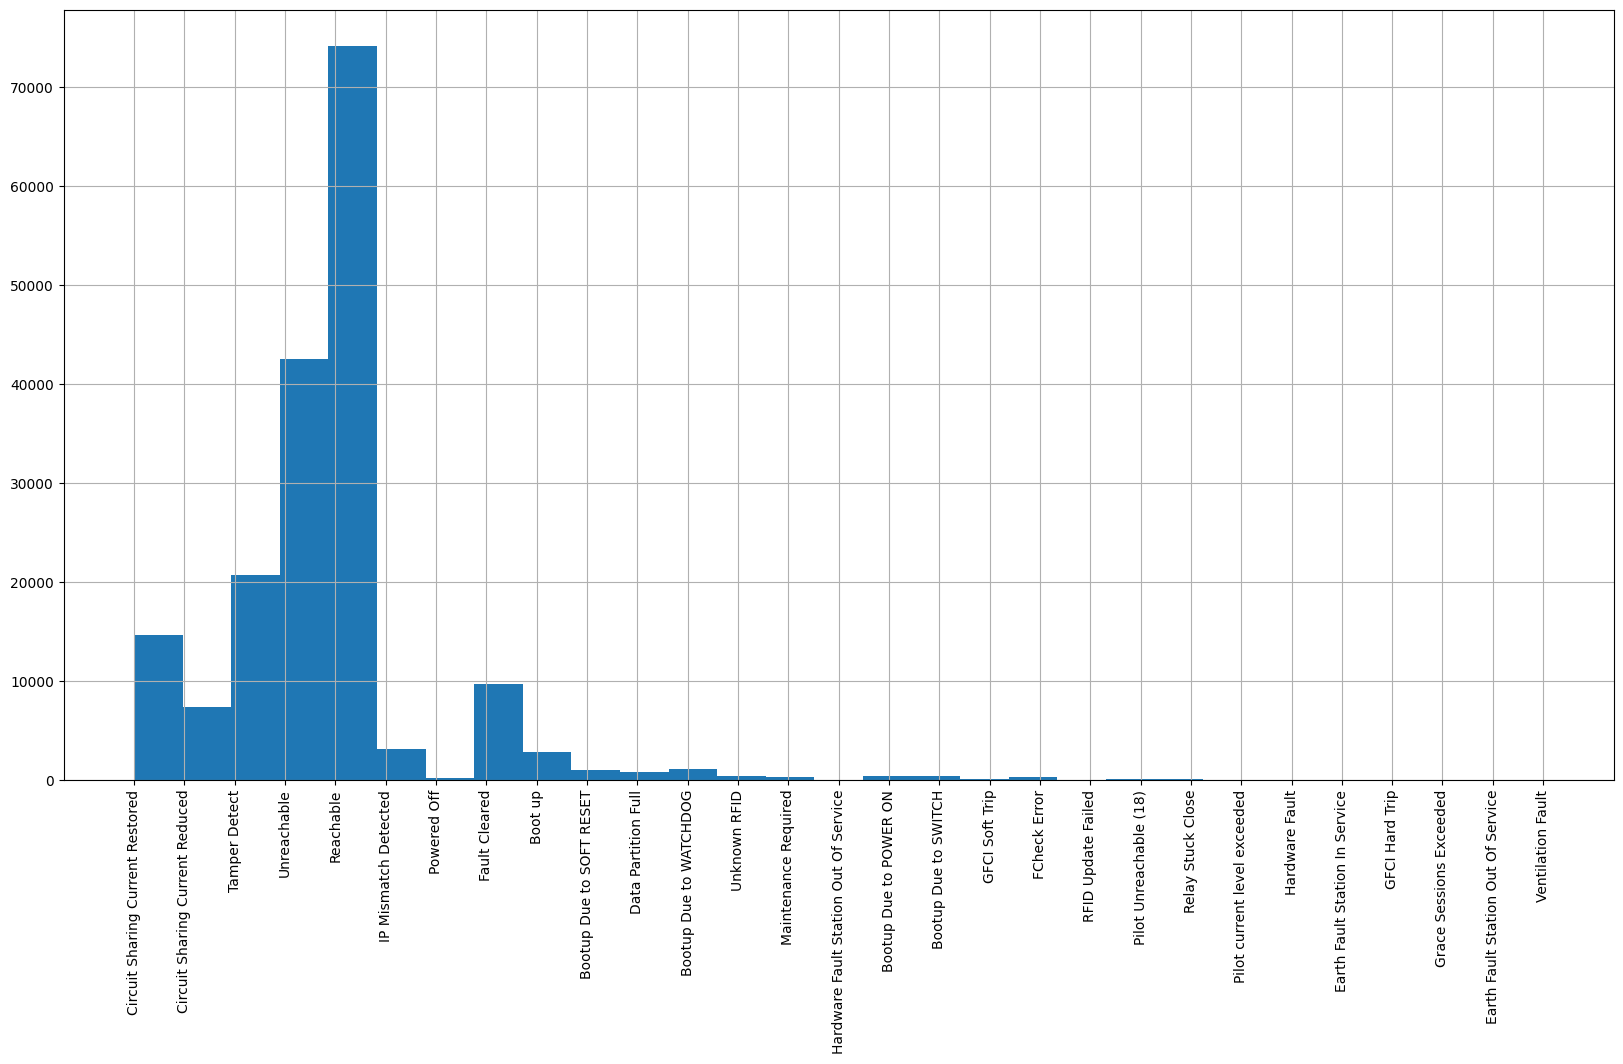

In [380]:
plt.figure(figsize=(20,10)) 
df_alarms['Alarm Name'].hist(xrot=90,bins=df_alarms['Alarm Name'].nunique())

Meaning of "Circuit Sharing Current Restored" and "Circuit Sharing Current Reduced"?
https://patents.google.com/patent/US8013570B2/en

In [381]:
df_alarms['Alarm Name'].unique()

array(['Circuit Sharing Current Restored',
       'Circuit Sharing Current Reduced', 'Tamper Detect', 'Unreachable',
       'Reachable', 'IP Mismatch Detected', 'Powered Off',
       'Fault Cleared', 'Boot up', 'Bootup Due to SOFT RESET',
       'Data Partition Full', 'Bootup Due to WATCHDOG', 'Unknown RFID',
       'Maintenance Required', 'Hardware Fault Station Out Of Service',
       'Bootup Due to POWER ON', 'Bootup Due to SWITCH', 'GFCI Soft Trip',
       'FCheck Error', 'RFID Update Failed', 'Pilot Unreachable (18)',
       'Relay Stuck Close', 'Pilot current level exceeded',
       'Hardware Fault', 'Earth Fault Station In Service',
       'GFCI Hard Trip', 'Grace Sessions Exceeded',
       'Earth Fault Station Out Of Service', 'Ventilation Fault'],
      dtype=object)

In [382]:
df_alarms['Alarm Name'].nunique()

29

In [383]:
df_alarms[df_alarms['Display Name']=='ROBLE / ROBLE LL1-10']

,Display Name,MAC Address,Org Name,Alarm Severity,Alarm Name,Alarm ID,FRU Name,Alarm Time,Model Number,Port,Reason For Clearing,Component Serial Number
0,ROBLE / ROBLE LL1-10,0024:B100:0004:5CE8,Stanford University,NaN,Circuit Sharing Current Restored,NaN,NaN,2023-09-26 14:47:28-07:00,CT4020-HD-GW,1.0,---,NaN
59,ROBLE / ROBLE LL1-10,0024:B100:0004:5CE8,Stanford University,NaN,Reachable,NaN,NaN,2023-09-26 11:16:43-07:00,CT4020-HD-GW,NaN,---,NaN
60,ROBLE / ROBLE LL1-10,0024:B100:0004:5CE8,Stanford University,NaN,IP Mismatch Detected,NaN,NaN,2023-09-26 11:16:43-07:00,CT4020-HD-GW,NaN,---,NaN
62,ROBLE / ROBLE LL1-10,0024:B100:0004:5CE8,Stanford University,NaN,Unreachable,NaN,NaN,2023-09-26 11:08:26-07:00,CT4020-HD-GW,NaN,---,NaN
67,ROBLE / ROBLE LL1-10,0024:B100:0004:5CE8,Stanford University,NaN,Unreachable,NaN,NaN,2023-09-26 10:58:26-07:00,CT4020-HD-GW,NaN,---,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
178649,ROBLE / ROBLE LL1-10,0024:B100:0004:5CE8,Stanford University,NaN,Bootup Due to SWITCH,NaN,NaN,2022-04-25 19:33:25-07:00,CT4020-HD-GW,NaN,---,NaN
178690,ROBLE / ROBLE LL1-10,0024:B100:0004:5CE8,Stanford University,NaN,Circuit Sharing Current Restored,NaN,NaN,2022-04-25 18:02:46-07:00,CT4020-HD-GW,1.0,---,NaN
178792,ROBLE / ROBLE LL1-10,0024:B100:0004:5CE8,Stanford University,NaN,Circuit Sharing Current Restored,NaN,NaN,2022-04-25 12:00:06-07:00,CT4020-HD-GW,2.0,---,NaN
178839,ROBLE / ROBLE LL1-10,0024:B100:0004:5CE8,Stanford University,NaN,Circuit Sharing Current Reduced,NaN,NaN,2022-04-25 09:17:38-07:00,CT4020-HD-GW,2.0,---,NaN


In [384]:
print(df_alarms['Alarm Name'].value_counts())

Alarm Name
Reachable                                74075
Unreachable                              42534
Tamper Detect                            20697
Circuit Sharing Current Restored         14634
Fault Cleared                             9684
Circuit Sharing Current Reduced           7377
IP Mismatch Detected                      3077
Boot up                                   2814
Bootup Due to WATCHDOG                    1125
Bootup Due to SOFT RESET                  1018
Data Partition Full                        766
Bootup Due to POWER ON                     407
Bootup Due to SWITCH                       388
Unknown RFID                               378
Maintenance Required                       331
FCheck Error                               252
Powered Off                                198
GFCI Soft Trip                              81
Relay Stuck Close                           77
Pilot Unreachable (18)                      45
RFID Update Failed                          11
Ha

In [385]:
print(df_alarms['Alarm Name'].value_counts()/len(df_alarms['Alarm Name']))

Alarm Name
Reachable                                0.411528
Unreachable                              0.236300
Tamper Detect                            0.114983
Circuit Sharing Current Restored         0.081300
Fault Cleared                            0.053800
Circuit Sharing Current Reduced          0.040983
IP Mismatch Detected                     0.017094
Boot up                                  0.015633
Bootup Due to WATCHDOG                   0.006250
Bootup Due to SOFT RESET                 0.005656
Data Partition Full                      0.004256
Bootup Due to POWER ON                   0.002261
Bootup Due to SWITCH                     0.002156
Unknown RFID                             0.002100
Maintenance Required                     0.001839
FCheck Error                             0.001400
Powered Off                              0.001100
GFCI Soft Trip                           0.000450
Relay Stuck Close                        0.000428
Pilot Unreachable (18)                 

## Proxy for Uptime

In [386]:
def get_uptime_for_single_charger(df_alarms,display_name,downtime_alarms,resample_freq='1s', verbose = True):
    aux = df_alarms[['Display Name','Alarm Name','Alarm Time']].copy(deep=True)
    sample = aux[aux['Display Name']==display_name]
    ## Print number of cases where alarm time is identical
    if verbose: print('total len: ',display_name,len(sample))
    df = sample.copy(deep=True)
    if verbose: print('identical time len: ',display_name,len(df[df['Alarm Time'].duplicated(keep=False)].sort_values('Alarm Time')))
    sample = sample.drop_duplicates(subset='Alarm Time', keep='first') # DROPPING FIRST CASE
    sample = sample.set_index('Alarm Time')
    if verbose: print('total len without duplicates: ',display_name,len(sample))
    ## Print number of cases where time is NaT
    if pd.isnull(sample.index).any():
        sample = sample.loc[sample.index.notnull()]
        if verbose: print('new len with no NaT or NaN: ',display_name,len(sample))
    sample = sample.resample(resample_freq).ffill()

    ## Calculate Uptime
    sample_total = len(sample)
    counts = sample['Alarm Name'].value_counts().to_dict()
    sample_down = 0
    for alarm in downtime_alarms:
        if alarm in counts.keys():
            sample_down = sample_down + counts[alarm]
    sample_up = sample_total-sample_down

    uptime = sample_up/sample_total*100
    downtime = sample_down/sample_total*100
    return uptime,downtime,sample_up,sample_down,sample_total


In [387]:
def get_uptime_system(df_alarms,downtime_alarms,resample_freq='1s',verbose=False):
    chargers_uptime_dict = {}
    total_alarms = 0
    total_up = 0
    total_down = 0
    aux = df_alarms[['Display Name','Alarm Name','Alarm Time']].copy(deep=True)
    chargers = list(aux['Display Name'].unique())
    for i in tqdm.tqdm(range(0,len(chargers))):
        charger = chargers[i]
        uptime,downtime,sample_up,sample_down,sample_total = get_uptime_for_single_charger(df_alarms,charger,downtime_alarms,resample_freq=resample_freq,verbose=verbose)
        chargers_uptime_dict[charger] = uptime
        total_up += sample_up
        total_down += sample_down
        total_alarms += sample_total
    total_uptime = total_up/total_alarms*100
    total_downtime = total_down/total_alarms*100
    chargers_uptime_dict['TOTAL UPTIME'] = total_uptime
    return chargers_uptime_dict, total_uptime, total_downtime, total_up, total_down, total_alarms


* Define downtime alarms
* Define resample freq

In [388]:
downtime_alarms = ['Tamper Detect', 
                   'Unreachable',
                   'IP Mismatch Detected', 
                   'Powered Off',
                   'Boot up', 
                   'Bootup Due to SOFT RESET',
                   'Data Partition Full', 
                   'Bootup Due to WATCHDOG', 
                   'Unknown RFID',
                   'Maintenance Required', 
                   'Hardware Fault Station Out Of Service',
                   'Bootup Due to POWER ON', 
                   'Bootup Due to SWITCH', 
                   'GFCI Soft Trip',
                   'FCheck Error', 
                   'RFID Update Failed', 
                   'Pilot Unreachable (18)',
                   'Relay Stuck Close', 
                   'Pilot current level exceeded',
                   'Hardware Fault', 
                   'Earth Fault Station In Service',
                   'GFCI Hard Trip', 
                   'Grace Sessions Exceeded',
                   'Earth Fault Station Out Of Service', 
                   'Ventilation Fault']
resample_freq = '10s'

### One charger example:

In [389]:
display_name = 'ROBLE / ROBLE LL1-10'
uptime,downtime,_,_,_ = get_uptime_for_single_charger(df_alarms,display_name,downtime_alarms,resample_freq=resample_freq,verbose=True)
print("Uptime: ",uptime)
print("Downtime: ",downtime)

total len:  ROBLE / ROBLE LL1-10 1767
identical time len:  ROBLE / ROBLE LL1-10 94
total len without duplicates:  ROBLE / ROBLE LL1-10 1720
Uptime:  94.8485328591489
Downtime:  5.151467140851098


### All chargers

60s resample freq

In [390]:
resample_freq = '60s'
chargers_uptime_dict, total_uptime, total_downtime, _,_,_ = get_uptime_system(df_alarms,downtime_alarms,resample_freq=resample_freq,verbose=False)
print("Uptime: ",total_uptime)
print("Downtime: ",total_downtime)

100%|██████████| 110/110 [00:05<00:00, 21.65it/s]

Uptime:  75.8833285470646
Downtime:  24.116671452935407


10s resample freq

In [391]:
resample_freq = '10s'
chargers_uptime_dict, total_uptime, total_downtime, _,_,_ = get_uptime_system(df_alarms,downtime_alarms,resample_freq=resample_freq,verbose=False)
print("Uptime: ",total_uptime)
print("Downtime: ",total_downtime)

  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 110/110 [00:23<00:00,  4.68it/s]

Uptime:  75.87457875036029
Downtime:  24.125421249639718


In [392]:
resample_freq = '1s'
chargers_uptime_dict, total_uptime, total_downtime, _,_,_ = get_uptime_system(df_alarms,downtime_alarms,resample_freq=resample_freq,verbose=False)
print("Uptime: ",total_uptime)
print("Downtime: ",total_downtime)

  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 110/110 [03:46<00:00,  2.06s/it]

Uptime:  75.87477566820078
Downtime:  24.125224331799224
